In [ ]:
import pandas as pd

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Capstone/

/content/drive/MyDrive/Capstone


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [ ]:
filename = '/content/drive/MyDrive/Capstone/foodclasses_model.pkl'
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 12)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 12, 128)        │        314,880 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128)            │         98,816 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_name_output (Dense) │ (None, 105)            │         13,545 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subclass_name_output      │ (None, 508)            │         65,532 │ bidirectional[0][0]    │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nova_output (Dense)       │ (None, 4)              │            516 │ bidirectional[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,479,869 (5.65 MB)

 Trainable params: 493,289 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 986,580 (3.76 MB)

In [ ]:
test_trans=pd.read_csv("/content/drive/MyDrive/Capstone/test_Data.csv")

In [ ]:
test_trans['Category'].value_counts()

,count
Category,
Ultra-Processed Foods,1614
Unprocessed or Minimally Processed Foods,352
Unknown,221
Processed Foods,204
Processed Culinary Ingredients,39


In [ ]:
test_trans.head()

,Products,Category
0,proton white burger rolls,Ultra-Processed Foods
1,pepsi pet,Ultra-Processed Foods
2,inkomaas gold,Unprocessed or Minimally Processed Foods
3,mega kapenta,Processed Foods
4,kefalos double plain yoghurt,Ultra-Processed Foods


In [ ]:
test_trans.iloc[:2,:].to_dict('records')
# basket

[{'Products': 'proton white burger rolls',
  'Category': 'Ultra-Processed Foods'},
 {'Products': 'pepsi pet', 'Category': 'Ultra-Processed Foods'}]

In [ ]:
nova_weights = {
    "Unprocessed or Minimally Processed Foods": 5,
    "Processed Culinary Ingredients": 4,
    "Processed Foods": 3,
    "Ultra-Processed Foods": 1,
    "Unknown": 0
}
test_trans['weight'] = test_trans['Category'].map(nova_weights)

In [ ]:
test_trans.iloc[:2,:].to_dict('records')


[{'Products': 'proton white burger rolls',
  'Category': 'Ultra-Processed Foods',
  'weight': 1},
 {'Products': 'pepsi pet', 'Category': 'Ultra-Processed Foods', 'weight': 1}]

In [ ]:
# Customer basket
test_trans.iloc[7:8].to_dict('records')

[{'Products': 'sweet potatoes ',
  'Category': 'Unprocessed or Minimally Processed Foods',
  'weight': 5}]

In [ ]:
filename = '/content/drive/MyDrive/Capstone/tokenizer.pkl'
# load the model from disk
tokenizer = pickle.load(open(filename, 'rb'))
filename = '/content/drive/MyDrive/Capstone/label_encoders.pkl'
# load the model from disk
label_encoders = pickle.load(open(filename, 'rb'))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
!pip install fuzzywuzzy[speedup]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.3 MB/s eta 0:00:00


**The Algorithm- Complete Package**

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
from fuzzywuzzy import process

def tokenize_item_description(item_description,  maxlen=12):
  tokenized_sequence = tokenizer.texts_to_sequences([item_description])
# Pad the tokenized sequence to a length of 12
  padded_sequence = pad_sequences(tokenized_sequence, maxlen).flatten()
  return padded_sequence

def predictions(padded_sequence):
  #predictions = loaded_model.predict(np.expand_dims(padded_sequence, axis=0))
  predictions = loaded_model.predict(np.expand_dims(padded_sequence, axis=0), verbose=0)

  pred_class_name = np.argmax(predictions[0],axis=1)
  pred_subclass_name = np.argmax(predictions[1], axis=1)
  pred_nova = np.argmax(predictions[2], axis=1)
  pred_class_name_labels = label_encoders['class_name'].inverse_transform(pred_class_name)
  pred_subclass_name_labels = label_encoders['subclass_name'].inverse_transform(pred_subclass_name)
  pred_nova_labels = label_encoders['nova'].inverse_transform(pred_nova)
  return pred_class_name_labels, pred_subclass_name_labels, pred_nova_labels


In [ ]:
def calculate_weighted_average(basket):
    total_weighted_score = sum(item['weight'] for item in basket)
    total_items = len(basket)
    if total_items == 0:
        return 0
    return total_weighted_score / total_items

def calculate_weighted(basket):
    total_weighted_score = sum(item[1] for item in basket)
    total_items = len(basket)
    if total_items == 0:
        return 0
    return total_weighted_score / total_items

def find_top_higher_weight_items(basket, items_df, top_n=10):
    # Create a DataFrame to store results
    basket_df = pd.DataFrame(basket)
    results = pd.DataFrame()

    # Iterate through each item in the customer's basket
    for index, row in basket_df.iterrows():
        subclass_name=predictions(tokenize_item_description(row['description']))[0][0]
        current_weight=nova_weights[predictions(tokenize_item_description(row['description']))[2][0]]

        # Find items of the same subclass with a higher weight
        higher_weight_items = items_df[
            (items_df['class_name'] == subclass_name) &
            (items_df['weight'] >= current_weight)
        ]

        # Append results to DataFrame
        results = pd.concat([results, higher_weight_items])
    # Check if results DataFrame is empty and handle it
    if results.empty:
        print("No higher weight items found.")
        return []  # Return an empty list if no higher weight items are found

    # Rank these items by weight and select the top N items
    top_items = results.sort_values(by='weight', ascending=False).drop_duplicates('description').head(top_n)

    return top_items.to_dict('records')

# Customer basket
basket = test_trans.iloc[7:8].to_dict('records')

# Customer's preferred items
preferred = ['VIRANI CURRY POWDER 10G']
#preferred_items=[]


In [ ]:
test_trans.iloc[7:8].to_dict('records')


[{'Products': 'sweet potatoes ',
  'Category': 'Unprocessed or Minimally Processed Foods',
  'weight': 5}]

In [ ]:
def predict_nova_classes(dataset):
    nova_predictions = []
    subclass_predictions = []
    class_predictions = []

    for index, row in dataset.iterrows():
        product_name = row['Products']
        padded_sequence = tokenize_item_description(product_name)
        pred_class_name_labels, pred_subclass_name_labels, pred_nova_labels = predictions(padded_sequence)
        nova_predictions.append(pred_nova_labels[0])
        subclass_predictions.append(pred_subclass_name_labels[0])
        class_predictions.append(pred_class_name_labels[0])

    dataset['predicted_nova'] = nova_predictions
    dataset['predicted_subclass'] = subclass_predictions
    dataset['predicted_class'] = class_predictions
    return dataset


df = pd.DataFrame(test_trans)
df = predict_nova_classes(df)

In [ ]:
df

,Products,Category,weight,predicted_nova,predicted_subclass,predicted_class
0,proton white burger rolls,Ultra-Processed Foods,1,Ultra-processed foods,PLAIN BUNS,BUNS/ROLLS
1,pepsi pet,Ultra-Processed Foods,1,Processed Culinary Ingredients,VEGETABLE FAT,COOKING FAT
2,inkomaas gold,Unprocessed or Minimally Processed Foods,5,Processed Culinary Ingredients,SUGARED PEANUTS,PASTRIES
3,mega kapenta,Processed Foods,3,Unprocessed/Minimally processed foods,FLAVOURED/FRUIT YOGHURT,FAST FOODS
4,kefalos double plain yoghurt,Ultra-Processed Foods,1,Ultra-processed foods,MARBLE CAKES,MARBLE CAKES
...,...,...,...,...,...,...
2425,pascall chocolate snack,Ultra-Processed Foods,1,Ultra-processed foods,BISCUITS,"COOKIES, BISCUITS AND WAFERS"
2426,esko noodle shrimp flavour,Ultra-Processed Foods,1,Ultra-processed foods,FLAVOURED MILK,CANDY AND CONFECTIONERY
2427,probrands brown rice,Unprocessed or Minimally Processed Foods,5,Ultra-processed foods,EDIBLE CLAY,CEREAL GRAINS
2428,green chillies,Unprocessed or Minimally Processed Foods,5,Processed Culinary Ingredients,SESAME/SIMSIM BAR,FRUITS


<ipython-input-22-796164b7fe5d>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='predicted_nova', data=df, palette=['#008fd5'])
<ipython-input-22-796164b7fe5d>:21: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(x='predicted_nova', data=df, palette=['#008fd5'])
<ipython-input-22-796164b7fe5d>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=0)


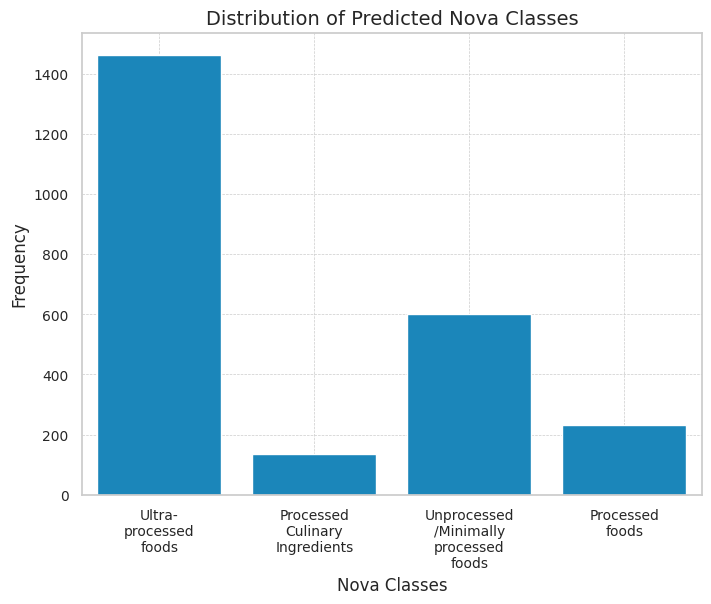

<ipython-input-22-796164b7fe5d>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_subclass', data=df.head(80), palette=['#fb4c33'])
<ipython-input-22-796164b7fe5d>:34: UserWarning: 
The palette list has fewer values (1) than needed (55) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='predicted_subclass', data=df.head(80), palette=['#fb4c33'])


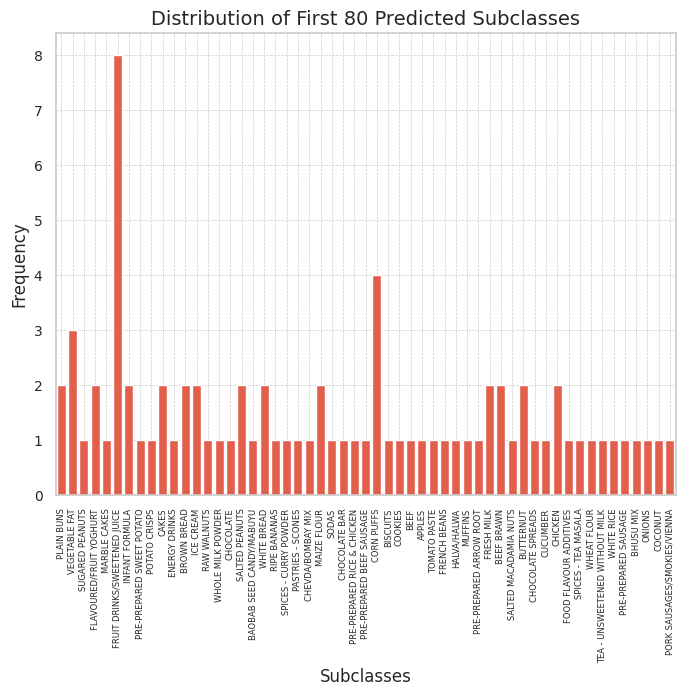

<ipython-input-22-796164b7fe5d>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_class', data=df, palette=['#e4ab3b'])
<ipython-input-22-796164b7fe5d>:45: UserWarning: 
The palette list has fewer values (1) than needed (87) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='predicted_class', data=df, palette=['#e4ab3b'])


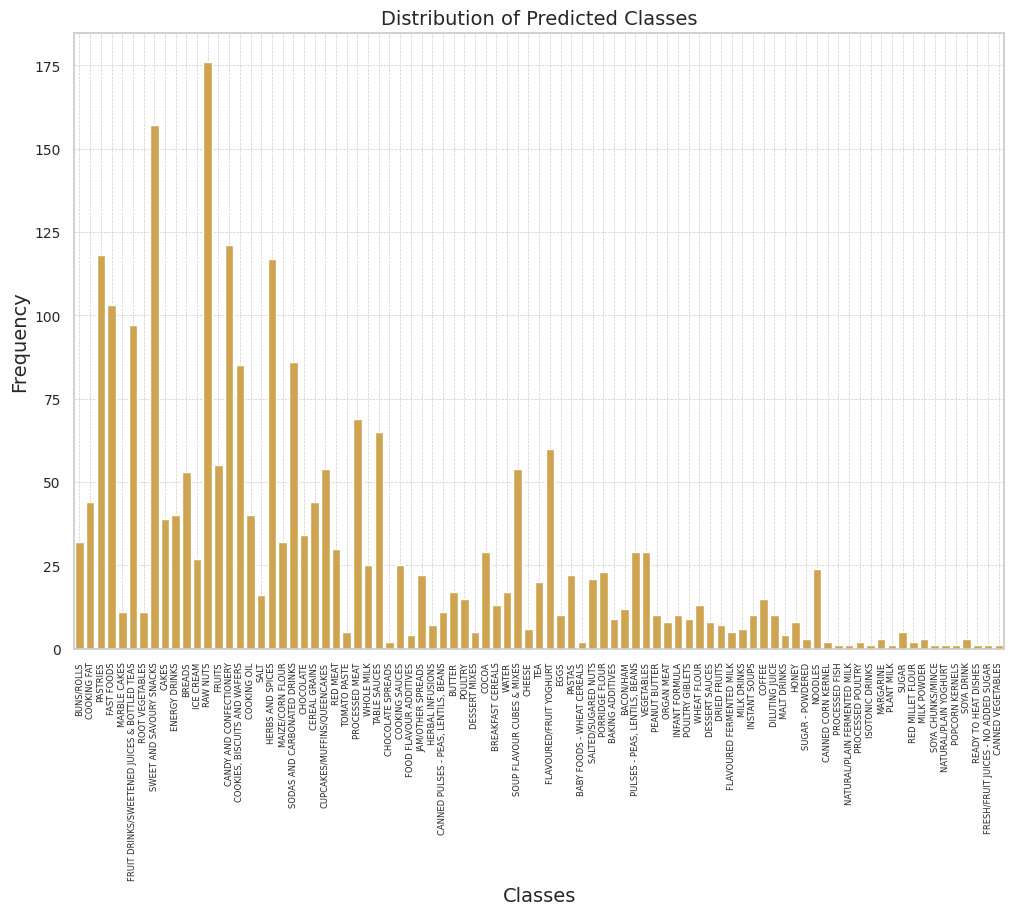

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# # Assuming df is the DataFrame with predictions
# df = pd.DataFrame(test_trans)
# df = predict_nova_classes(df)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

    # Function to wrap labels
def wrap_labels(ax, width):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0)

def plot_predictions_distribution(df):
    # Plotting the predicted nova distribution
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='predicted_nova', data=df, palette=['#008fd5'])
    plt.title('Distribution of Predicted Nova Classes', fontsize=14)
    plt.xlabel('Nova Classes', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    wrap_labels(ax, 11)  # Wrap labels to fit within 10 characters
    plt.show()

    # Plotting the predicted subclass distribution
    plt.figure(figsize=(8, 6))
    # fig, ax = plt.subplots(figsize=(8, 4))  # Reduced figure size
    sns.countplot(x='predicted_subclass', data=df.head(80), palette=['#fb4c33'])
    plt.title('Distribution of First 80 Predicted Subclasses', fontsize=14)
    plt.xlabel('Subclasses', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=6, rotation=90)
    plt.yticks(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

    # Plotting the predicted class distribution
    plt.figure(figsize=(12, 8))
    sns.countplot(x='predicted_class', data=df, palette=['#e4ab3b'])
    plt.title('Distribution of Predicted Classes', fontsize=14)
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=6, rotation=90)
    plt.yticks(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Call the function to plot the distributions
plot_predictions_distribution(df)


In [ ]:
# Slice the DataFrame to get only items from the 100th row onwards
df_subset = df.iloc[101:201]

# Function to style the DataFrame
def style_predictions(df):
    return df.style \
        .highlight_max(color='lightgreen', subset=['predicted_nova', 'predicted_subclass', 'predicted_class']) \
        .highlight_min(color='lightcoral', subset=['predicted_nova', 'predicted_subclass', 'predicted_class']) \
        .set_properties(**{'background-color': '#f9f9f9', 'color': 'black', 'border-color': 'black'}) \
        .set_table_styles([{
            'selector': 'thead th',
            'props': [('background-color', '#4f81bd'), ('color', 'white'), ('font-size', '12px')]
        }, {
            'selector': 'tbody td',
            'props': [('font-size', '10px')]
        }])


# Apply the styling to the subset DataFrame
styled_df = style_predictions(df_subset)

# Display the styled DataFrame
# styled_df = style_predictions(df)
styled_df


,Products,Category,weight,predicted_nova,predicted_subclass,predicted_class
101,hunters dry nrb,Ultra-Processed Foods,1,Ultra-processed foods,PRE-PREPARED CHIPS,CUPCAKES/MUFFINS/QUEENCAKES
102,colcom tastee beef polony,Ultra-Processed Foods,1,Ultra-processed foods,BEEF BRAWN,PROCESSED MEAT
103,choc chip cookies,Ultra-Processed Foods,1,Ultra-processed foods,COOKIES,"COOKIES, BISCUITS AND WAFERS"
104,iris ginger biscuits,Ultra-Processed Foods,1,Ultra-processed foods,BISCUITS,"COOKIES, BISCUITS AND WAFERS"
105,royal ocean pilchards in chili,Processed Foods,3,Ultra-processed foods,READY TO HEAT GITHERI,FAST FOODS
106,big brother mixed portions,Ultra-Processed Foods,1,Ultra-processed foods,SALTED MIXED NUTS,BUTTER
107,pure seasons paprika jar,Ultra-Processed Foods,1,Unprocessed/Minimally processed foods,SPICES - PAPRIKA,HERBS AND SPICES
108,cadbury eclairs,Ultra-Processed Foods,1,Ultra-processed foods,SWEETS/CANDY,CANDY AND CONFECTIONERY
109,mega jasmine rice,Unprocessed or Minimally Processed Foods,5,Unprocessed/Minimally processed foods,WHITE RICE,CEREAL GRAINS
110,shotts whisky,Ultra-Processed Foods,1,Processed foods,CORN PUFFS,RAW NUTS


In [ ]:
!pip install prettytable

In [ ]:
from prettytable import PrettyTable

# Sample data for demonstration
association_rules = [
    ("Garfunkels Family Polony --> Lobels Prime White Loaf", "High Confidence", "Nova Classification 1"),
    ("Rule 2", "Medium Confidence", "Nova Classification 2"),
    ("Rule 3", "Low Confidence", "Nova Classification 3"),
    ("Rule 4", "High Confidence", "Nova Classification 4"),
]

# Initialize PrettyTable
table = PrettyTable()

# Add columns
table.field_names = ["Association Rule", "Confidence", "Nova Classification"]

# Add rows
for rule, confidence, classification in association_rules:
    table.add_row([rule, confidence, classification])

# Display the table
print(table)


+------------------+-------------------+-----------------------+
| Association Rule |     Confidence    |  Nova Classification  |
+------------------+-------------------+-----------------------+
|      Rule 1      |  High Confidence  | Nova Classification 1 |
|      Rule 2      | Medium Confidence | Nova Classification 2 |
|      Rule 3      |   Low Confidence  | Nova Classification 3 |
|      Rule 4      |  High Confidence  | Nova Classification 4 |
+------------------+-------------------+-----------------------+


In [ ]:
from prettytable import PrettyTable, SINGLE_BORDER

# Data extracted from the image
association_rules = [
    ("('HULETTS BROWN SUGAR', 'MEGA TOP CHEF PREM WHITE RICE')", "'RAHA SOYA COOKING OIL'", 0.4072),
    ("('HULETTS BROWN SUGAR', 'RAHA SOYA COOKING OIL')", "'MEGA TOP CHEF PREM WHITE RICE'", 0.1475),
    ("('MEGA TOP CHEF PREM WHITE RICE', 'RAHA SOYA COOKING OIL')", "'HULETTS BROWN SUGAR'", 0.5490),
    ("HULETTS BROWN SUGAR", "('MEGA TOP CHEF PREM WHITE RICE', 'RAHA SOYA COOKING OIL')", 0.02349),
    ("MEGA TOP CHEF PREM WHITE RICE", "('HULETTS BROWN SUGAR', 'RAHA SOYA COOKING OIL')", 0.0987),
    ("RAHA SOYA COOKING OIL", "('HULETTS BROWN SUGAR', 'MEGA TOP CHEF PREM WHITE RICE')", 0.0343),

    ("'LOBELS PRIME WHITE LOAF'", "'MIRINDA FRUITY PET'", 0.0241),
    ("'MIRINDA FRUITY PET'", "'LOBELS PRIME WHITE LOAF'", 0.0384),
    ("'GARFUNKELS FAMILY POLONY'", "'MIRINDA FRUITY PET'", 0.0384),
    ("'MIRINDA FRUITY PET'", "'GARFUNKELS FAMILY POLONY'", 0.0461),
    ("'HULETTS BROWN SUGAR'", "'MIRINDA FRUITY PET'", 0.0225),
    ("'MIRINDA FRUITY PET'", "'HULETTS BROWN SUGAR'", 0.0227),
    ("'MIRINDA FRUITY PET'", "'PLAIN BUN EACH'", 0.0446),
    ("'PLAIN BUN EACH'", "'MIRINDA FRUITY PET'", 0.0225),
    ("'FW TEA LOAF'", "'MIRINDA FRUITY PET'", 0.0602),
    ("'MIRINDA FRUITY PET'", "'FW TEA LOAF'", 0.0271),

    ("'BAKERS INN WHITE LOAF'", "'MIRINDA FRUITY PET'", 0.0242),
    ("'MIRINDA FRUITY PET'", "'BAKERS TIN WHITE LOAF'", 0.0406),
    ("'MIRINDA FRUITY PET'", "'PEPSI PET'", 0.0531),
    ("'PEPSI PET'", "'MIRINDA FRUITY PET'", 0.0622),

    ("('BAKERS INN WHITE LOAF', 'HULETTS BROWN SUGAR')", "'LOBELS PRIME WHITE LOAF'", 0.0140),
    ("('BAKERS INN WHITE LOAF', 'LOBELS PRIME WHITE LOAF')", "'HULETTS BROWN SUGAR'", 0.02552),
    ("('HULETTS BROWN SUGAR', 'LOBELS PRIME WHITE LOAF')", "'BAKERS INN WHITE LOAF'", 0.0153),
    ("BAKERS INN WHITE LOAF", "('HULETTS BROWN SUGAR', 'LOBELS PRIME WHITE LOAF')", 0.0026),
    ("HULETTS BROWN SUGAR", "('BAKERS INN WHITE LOAF', 'LOBELS PRIME WHITE LOAF')", 0.0032),
    ("LOBELS PRIME WHITE LOAF", "('BAKERS INN WHITE LOAF', 'HULETTS BROWN SUGAR')", 0.0026),
    ("BAKERS INN WHITE LOAF", "'HULETTS BROWN SUGAR'", 0.1915),
    ("HULETTS BROWN SUGAR", "'BAKERS INN WHITE LOAF'", 0.2306),
    ("BAKERS INN WHITE LOAF", "'LOBELS PRIME WHITE LOAF'", 0.1052),
    ("LOBELS PRIME WHITE LOAF", "'BAKERS INN WHITE LOAF'", 0.1028),
    ("HULETTS BROWN SUGAR", "'LOBELS PRIME WHITE LOAF'", 0.2110),
    ("LOBELS PRIME WHITE LOAF", "'HULETTS BROWN SUGAR'", 0.1713),

    ("GARFUNKELS FAMILY POLONY", "LOBELS PRIME WHITE LOAF", 0.3859),
    ("LOBELS PRIME WHITE LOAF", "GARFUNKELS FAMILY POLONY", 0.3401),
    ("BAKERS INN WHITE LOAF", "LOBELS PRIME WHITE LOAF", 0.1413),
    ("LOBELS PRIME WHITE LOAF", "BAKERS INN WHITE LOAF", 0.1485),
    ("GARFUNKELS FAMILY POLONY", "PLAIN BUN EACH", 0.2744),
    ("PLAIN BUN EACH", "GARFUNKELS FAMILY POLONY", 0.1946),
    ("BAKERS INN WHITE LOAF", "GARFUNKELS FAMILY POLONY", 0.3055),
    ("GARFUNKELS FAMILY POLONY", "BAKERS INN WHITE LOAF", 0.3644),
]

# Convert all words to lowercase
association_rules_lowercase = [(rule.lower(), consequent.lower(), confidence) for rule, consequent, confidence in association_rules]


# # Convert all words to lowercase, handling potential extra elements
# association_rules_lowercase = [
#     (rule.lower(), consequent.lower(), confidence)
#     if len(item) == 3 else
#     (item[0].lower(), item[1].lower(), item[2])  # Handle items with 4 elements
#     for item in association_rules
# ]

# Sort the association rules by confidence in descending order
association_rules_sorted = sorted(association_rules, key=lambda x: x[2], reverse=True)

# Initialize PrettyTable
table = PrettyTable()

# Add columns
table.field_names = ["Association Rule", "Consequent", "Confidence"]

# # Add rows
# for rule, consequent, confidence in association_rules:
#     table.add_row([rule, consequent, confidence])

# # Display the table
# print(table)

# Add rows
for rule, consequent, confidence in association_rules_sorted:
    table.add_row([rule, consequent, confidence])
    table.add_row(['-'*20, '-'*20, '-'*20])

# Adjust the table style
table.set_style(SINGLE_BORDER)

# Remove the last separator row
table.del_row(len(table._rows) - 1)

# Display the table
print(table)

┌────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────┬──────────────────────┐
│                      Association Rule                      │                         Consequent                         │      Confidence      │
├────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────────────────────┤
│ ('MEGA TOP CHEF PREM WHITE RICE', 'RAHA SOYA COOKING OIL') │                   'HULETTS BROWN SUGAR'                    │        0.549         │
│                    --------------------                    │                    --------------------                    │ -------------------- │
│  ('HULETTS BROWN SUGAR', 'MEGA TOP CHEF PREM WHITE RICE')  │                  'RAHA SOYA COOKING OIL'                   │        0.4072        │
│                    --------------------                    │                    --------------------                

In [ ]:
from prettytable import PrettyTable, SINGLE_BORDER

# Data extracted from the image
association_rules = [
    ("('HULETTS BROWN SUGAR', 'MEGA TOP CHEF PREM WHITE RICE')", "'RAHA SOYA COOKING OIL'", 0.4072, "PCI, UF"),
    ("('HULETTS BROWN SUGAR', 'RAHA SOYA COOKING OIL')", "'MEGA TOP CHEF PREM WHITE RICE'", 0.1475, "PCI, UF"),
    ("('MEGA TOP CHEF PREM WHITE RICE', 'RAHA SOYA COOKING OIL')", "'HULETTS BROWN SUGAR'", 0.5490, "PCI, UF"),
    ("HULETTS BROWN SUGAR", "('MEGA TOP CHEF PREM WHITE RICE', 'RAHA SOYA COOKING OIL')", 0.02349, "PCI, UF"),
    ("MEGA TOP CHEF PREM WHITE RICE", "('HULETTS BROWN SUGAR', 'RAHA SOYA COOKING OIL')", 0.0987, "PCI, UF"),
    ("RAHA SOYA COOKING OIL", "('HULETTS BROWN SUGAR', 'MEGA TOP CHEF PREM WHITE RICE')", 0.0343, "PCI, UF"),

    ("'LOBELS PRIME WHITE LOAF'", "'MIRINDA FRUITY PET'", 0.0241, "UPF"),
    ("'MIRINDA FRUITY PET'", "'LOBELS PRIME WHITE LOAF'", 0.0384, "UPF"),
    ("'GARFUNKELS FAMILY POLONY'", "'MIRINDA FRUITY PET'", 0.0384, "UPF"),
    ("'MIRINDA FRUITY PET'", "'GARFUNKELS FAMILY POLONY'", 0.0461, "UPF"),
    ("'HULETTS BROWN SUGAR'", "'MIRINDA FRUITY PET'", 0.0225, "PCI, UPF"),
    ("'MIRINDA FRUITY PET'", "'HULETTS BROWN SUGAR'", 0.0227, "PCI, UPF"),
    ("'MIRINDA FRUITY PET'", "'PLAIN BUN EACH'", 0.0446, "UPF"),
    ("'PLAIN BUN EACH'", "'MIRINDA FRUITY PET'", 0.0225, "UPF"),
    ("'FW TEA LOAF'", "'MIRINDA FRUITY PET'", 0.0602, "UPF"),
    ("'MIRINDA FRUITY PET'", "'FW TEA LOAF'", 0.0271, "UPF"),

    ("'BAKERS INN WHITE LOAF'", "'MIRINDA FRUITY PET'", 0.0242, "UPF"),
    ("'MIRINDA FRUITY PET'", "'BAKERS TIN WHITE LOAF'", 0.0406, "UPF"),
    ("'MIRINDA FRUITY PET'", "'PEPSI PET'", 0.0531, "UPF"),
    ("'PEPSI PET'", "'MIRINDA FRUITY PET'", 0.0622, "UPF"),

    ("('BAKERS INN WHITE LOAF', 'HULETTS BROWN SUGAR')", "'LOBELS PRIME WHITE LOAF'", 0.0140, "PCI, UPF"),
    ("('BAKERS INN WHITE LOAF', 'LOBELS PRIME WHITE LOAF')", "'HULETTS BROWN SUGAR'", 0.02552, "PCI, UPF"),
    ("('HULETTS BROWN SUGAR', 'LOBELS PRIME WHITE LOAF')", "'BAKERS INN WHITE LOAF'", 0.0153, "PCI, UPF"),
    ("BAKERS INN WHITE LOAF", "('HULETTS BROWN SUGAR', 'LOBELS PRIME WHITE LOAF')", 0.0026, "PCI, UPF"),
    ("HULETTS BROWN SUGAR", "('BAKERS INN WHITE LOAF', 'LOBELS PRIME WHITE LOAF')", 0.0032, "PCI, UPF"),
    ("LOBELS PRIME WHITE LOAF", "('BAKERS INN WHITE LOAF', 'HULETTS BROWN SUGAR')", 0.0026, "PCI, UPF"),
    ("BAKERS INN WHITE LOAF", "'HULETTS BROWN SUGAR'", 0.1915, "PCI, UPF"),
    ("HULETTS BROWN SUGAR", "'BAKERS INN WHITE LOAF'", 0.2306, "PCI, UPF"),
    ("BAKERS INN WHITE LOAF", "'LOBELS PRIME WHITE LOAF'", 0.1052, "UPF"),
    ("LOBELS PRIME WHITE LOAF", "'BAKERS INN WHITE LOAF'", 0.1028, "UPF"),
    ("HULETTS BROWN SUGAR", "'LOBELS PRIME WHITE LOAF'", 0.2110, "PCI, UPF"),
    ("LOBELS PRIME WHITE LOAF", "'HULETTS BROWN SUGAR'", 0.1713, "PCI, UPF"),

    ("GARFUNKELS FAMILY POLONY", "LOBELS PRIME WHITE LOAF", 0.3859, "UPF"),
    ("LOBELS PRIME WHITE LOAF", "GARFUNKELS FAMILY POLONY", 0.3401, "UPF"),
    ("BAKERS INN WHITE LOAF", "LOBELS PRIME WHITE LOAF", 0.1413, "UPF"),
    ("LOBELS PRIME WHITE LOAF", "BAKERS INN WHITE LOAF", 0.1485, "UPF"),
    ("GARFUNKELS FAMILY POLONY", "PLAIN BUN EACH", 0.2744, "UPF"),
    ("PLAIN BUN EACH", "GARFUNKELS FAMILY POLONY", 0.1946, "UPF"),
    ("BAKERS INN WHITE LOAF", "GARFUNKELS FAMILY POLONY", 0.3055, "UPF"),
    ("GARFUNKELS FAMILY POLONY", "BAKERS INN WHITE LOAF", 0.3644, "UPF"),
]

# Convert all words to lowercase
association_rules_lowercase = [(rule.lower(), consequent.lower(), confidence, nova.lower()) for rule, consequent, confidence, nova in association_rules]


# Sort the association rules by confidence in descending order
association_rules_sorted = sorted(association_rules_lowercase, key=lambda x: x[2], reverse=True)

# Initialize PrettyTable
table = PrettyTable()

# Add columns
table.field_names = ["Association Rule", "Consequent", "Confidence", "Nova"]

# Add rows
for rule, consequent, confidence, nova in association_rules_sorted:
    table.add_row([rule, consequent, confidence, nova])
    table.add_row(['-'*20, '-'*20, '-'*20, '-'*20])

# Adjust the table style
table.set_style(SINGLE_BORDER)

# Remove the last separator row
table.del_row(len(table._rows) - 1)

# Display the table
print(table)

┌────────────────────────────────────────────────────────────┬────────────────────────────────────────────────────────────┬──────────────────────┬──────────────────────┐
│                      Association Rule                      │                         Consequent                         │      Confidence      │         Nova         │
├────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────────────┼──────────────────────┼──────────────────────┤
│ ('mega top chef prem white rice', 'raha soya cooking oil') │                   'huletts brown sugar'                    │        0.549         │       pci, uf        │
│                    --------------------                    │                    --------------------                    │ -------------------- │ -------------------- │
│  ('huletts brown sugar', 'mega top chef prem white rice')  │                  'raha soya cooking oil'                   │        0.4072        │    

In [ ]:
!apt-get install -y fonts-dejavu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra
The following NEW packages will be installed:
  fonts-dejavu fonts-dejavu-core fonts-dejavu-extra
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 3,085 kB of archives.
After this operation, 10.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-dejavu all 2.37-2build1 [3,192 B]
Fetched 3,085 kB in 1s (3,174 kB/s)
Selecting previously unselected package fonts-dejavu-core.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../fonts-dejavu-core_2.37-2build1_all.deb ...
Unpack

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# Convert PrettyTable to string
table_string = table.get_string()

# Create an image from the table string
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # Ensure this path is correct
font = ImageFont.truetype(font_path, 14)
padding = 10

# Calculate image size
lines = table_string.split('\n')
max_width = max(font.getsize(line)[0] for line in lines)
max_height = font.getsize(lines[0])[1]
img_width = max_width + 2 * padding
img_height = max_height * len(lines) + 2 * padding

# Create a new image with white background
image = Image.new('RGB', (img_width, img_height), 'white')
draw = ImageDraw.Draw(image)

# Draw the text on the image
y_text = padding
for line in lines:
    draw.text((padding, y_text), line, font=font, fill='black')
    y_text += max_height

# Save the image
image.save('/content/drive/MyDrive/Capstone/association_rules_table.png')

# Display the image
image.show()

<ipython-input-45-628631185caa>:13: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  max_width = max(font.getsize(line)[0] for line in lines)
<ipython-input-45-628631185caa>:14: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  max_height = font.getsize(lines[0])[1]


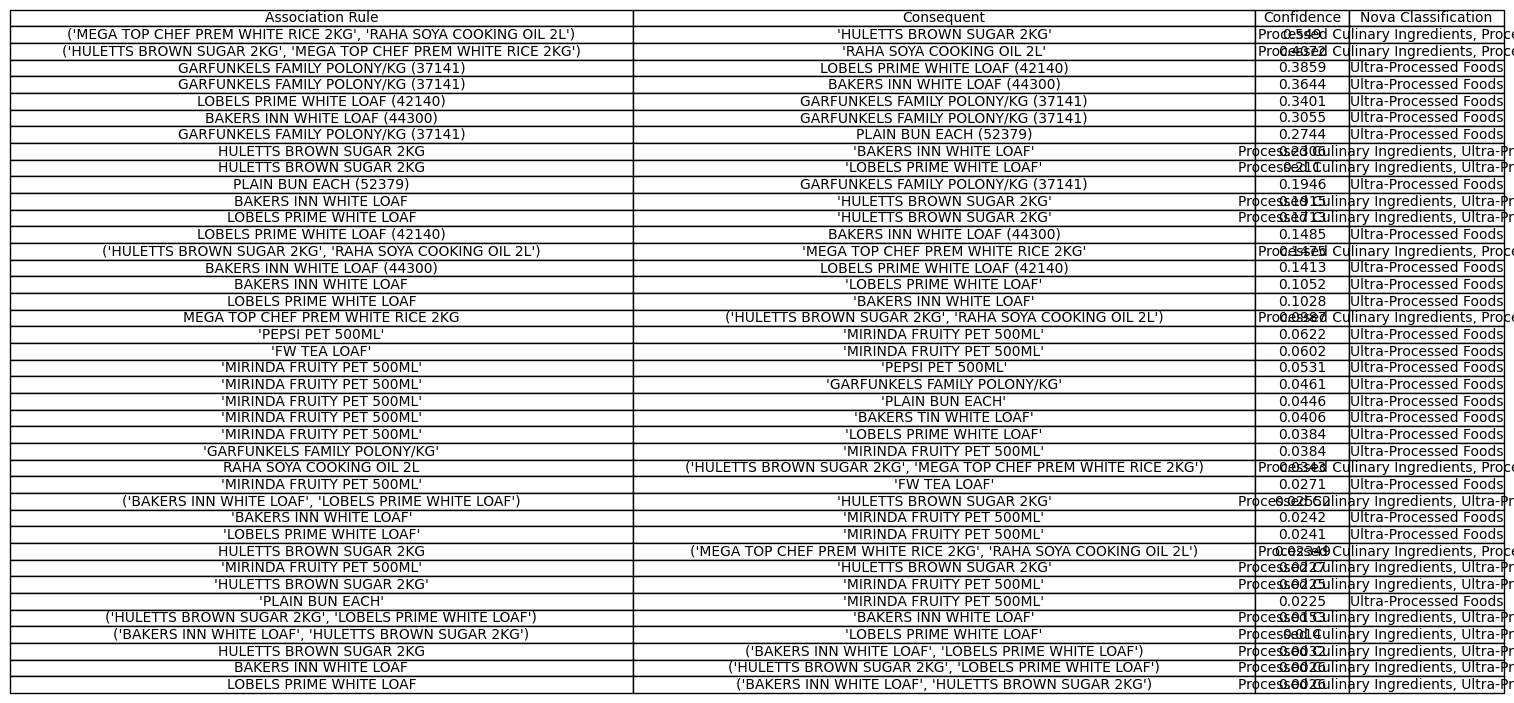

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame for better handling with matplotlib
df = pd.DataFrame(association_rules_sorted, columns=["Association Rule", "Consequent", "Confidence", "Nova Classification"])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the size as needed

# Hide the axes
ax.axis('off')
ax.axis('tight')

# Create a table
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust column width
table.auto_set_column_width([0, 1, 2])

# Save the table as a PNG file
plt.savefig('association_rules_table.png', bbox_inches='tight', dpi=300)

# Display the table
plt.show()